In [475]:
import pandas as pd
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
# from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as kb
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min



In [476]:
frames = 20
startvid=0
endvid=1

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict)

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)





In [469]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [470]:
# tf.test.is_gpu_available()

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [471]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [472]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [473]:
def Files_Load():
    train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
    test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"
    box_train_txt = os.listdir(train_file)
    box_train_txt.sort()
    box_test_txt = os.listdir(test_file)
    box_test_txt.sort()
    
    loc_files_train, loc_files_test = [], []
    
    for txt in box_train_txt:
        loc_files_train.append(train_file + txt)
    for txt in box_test_txt:
        loc_files_test.append(test_file + txt)
    
    return loc_files_train, loc_files_test, box_train_txt, box_test_txt

# Faster Data Loader

In [7]:
def Boxes(loc_files, txt_names, time_steps, pad ='pre'):
    """
    loc_files: List that contains that has text files save
    txt_names: Txt file names. For visualization process
    time_step: Sequence length input
    pad: inputs 'pre' or 'post'
    
    x_person_box: Has bounding box locations
    y_person_box: Label for bounding box locations
    frame_person_id: Contains frame Number and person_Id of entire sequence, 
                     Last element is prediction frame. For visulization process
    video_file: Points to video file used. For visulization process
    """
    
    x_ppl_box, y_ppl_box, frame_ppl_id, video_file, abnormal = [], [], [], [],[]  #Has bounding box locations inside
    
    #For splitting process
    split_train_test = 0
    split = 0
    find_split = 0
    
    # Tells me how many in sequence was short.
    # Do I want to go back and count for train and test seperatly 
    short_len = 0
    
#     datadict = OrderedDict()
    datadict = {}
    
    for loc, txt_name in zip(loc_files, txt_names):
        data = pd.read_csv(loc, ' ' )
        # Note that person_box is 1 behind ID
        max_person = data['Person_ID'].max()
        for num in range(1,max_person+1):
            temp_box = data[data['Person_ID'] == num ]['BB_tl_0	BB_tl_1	BB_br_0	BB_br_1'.split()].values
            person_seq_len = len(temp_box)
            temp_frame_id = data[data['Person_ID'] == num ]['Frame_Number Person_ID'.split()].values
            abnormal_frame_ped = data[data['Person_ID'] == num]['anomaly'].values
            if person_seq_len > time_steps:
                for i in range(0, person_seq_len - time_steps):
                    temp_person_box = temp_box[i:(i+time_steps)]
                    temp_fr_person_id = temp_frame_id[i:(i+time_steps+1)]

                    x_ppl_box.append(temp_person_box)
                    y_ppl_box.append(temp_box[i+time_steps])
                    
                    assert temp_person_box.shape == (time_steps,4)
                    assert temp_fr_person_id.shape  == (time_steps+1,2), print(temp_fr_person_id.shape)
                    
                    frame_ppl_id.append(temp_fr_person_id)
                    
                    video_file.append(txt_name)      
                    abnormal.append(abnormal_frame_ped[i+time_steps]) #Finds if predicted frame is abnormal
                    
            elif person_seq_len == 1:
                # want it to skip loop
                continue
            elif person_seq_len <= time_steps:
                temp_person_box_unpad = temp_box
                temp_fr_person_id_unpad = temp_frame_id
                temp_person_box = pad_sequences(temp_person_box_unpad.T, maxlen = time_steps+1, padding = pad).T
                temp_fr_person_id = pad_sequences(temp_fr_person_id_unpad.T,  maxlen = time_steps+1, padding = pad).T
                
                assert temp_person_box.shape == (time_steps+1,4)
                assert temp_fr_person_id.shape  == (time_steps+1,2)
                
                x_ppl_box.append(temp_person_box[0:time_steps,:])
                y_ppl_box.append(temp_person_box[time_steps,:])
                
                frame_ppl_id.append(temp_fr_person_id[0:time_steps+1,:])
                
                video_file.append(txt_name)
                abnormal.append(abnormal_frame_ped[-1]) #Finds if predicted frame is abnormal

            else:
                print('error')
#     np.random.seed(49)
#     rand = np.random.permutation(len(x_ppl_box))
#     datadict['x_ppl_box'] = np.array(x_ppl_box)[rand]
#     datadict['y_ppl_box'] = np.array(y_ppl_box)[rand]
#     datadict['frame_ppl_id'] = np.array(frame_ppl_id)[rand]
#     datadict['video_file'] = np.array(video_file)[rand]
#     datadict['abnormal'] = np.array(abnormal)[rand]

    datadict['x_ppl_box'] = np.array(x_ppl_box)
    datadict['y_ppl_box'] = np.array(y_ppl_box)
    datadict['frame_ppl_id'] = np.array(frame_ppl_id)
    datadict['video_file'] = np.array(video_file)
    datadict['abnormal'] = np.array(abnormal)
        
    return  datadict

# Video Plot Function

# Metrics

In [8]:
def bb_intersection_over_union(y, x):
    xA = kb.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = kb.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = kb.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = kb.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = kb.max((kb.zeros_like(xB), (xB-xA +1) ), axis=0, keepdims=True)
    interArea2 = kb.max((kb.zeros_like(xB), (yB-yA +1) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] + 1) * (x[:,3:4] - x[:,1:2] + 1)
    boxBArea = (y[:,2:3] - y[:,0:1] + 1) * (y[:,3:4] - y[:,1:2] + 1)

    iou = interArea / (boxAArea + boxBArea - interArea)
    iou_mean = -kb.mean(iou)
    return iou_mean

# Loading with 20 frames

In [257]:
loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load()
start = time.time()
# x_ppl_box, y_ppl_box, frame_ppl_id, video_file,trialdict = Boxes(loc_files_train, box_train_txt, 20, pad ='pre')
traindict = Boxes(loc_files_train, box_train_txt, 20, pad ='pre')
end = time.time()
print(end -start)

3.0685737133026123


In [414]:
start = time.time()

testdict = Boxes(loc_files_test[0:1], box_test_txt[0:1], 20, pad ='pre')
end = time.time()
print(end -start)

0.2543485164642334


In [415]:
traindict['video_file']

array(['01.txt', '01.txt', '01.txt', ..., '16.txt', '16.txt', '16.txt'],
      dtype='<U6')

In [304]:
loc_files_test[0:23]

['/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/01.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/02.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/03.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/04.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/05.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/06.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/07.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/08.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/09.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/10.txt',
 '/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/11.txt',
 '/home/ak

In [305]:
def getDict(frames =20, startvid=0,endvid=1 ):
    loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load()
    traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
    testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
    return traindict,testdict


    

In [259]:
def test_sepearate_norm_abnorm(testdict):
    abnormal_index = np.nonzero(testdict['abnormal'])
    normal_index = np.where(testdict['abnormal'] == 0)
    normal_dict = {}
    abnormal_dict = {}
    
    for key in testdict.keys():
        normal_dict[key] = testdict[key][normal_index]
        abnormal_dict[key] = testdict[key][abnormal_index]
    

    return abnormal_dict, normal_dict
    

In [260]:
def normalize_train_max_min(traindict = None, testdict = None, unnorm_data = None, unorm=False):
    
    max1 = traindict['x_ppl_box'].max()
    min1 = traindict['x_ppl_box'].min()
    if unorm:
        data = unnorm_data*(max1-min1) + min1
        return data
    
    else:
        abnormal_dict, normal_dict = test_sepearate_norm_abnorm(testdict)

        abnormal_test_x = abnormal_dict['x_ppl_box']
        abnormal_test_y = abnormal_dict['y_ppl_box']
        test_x = normal_dict['x_ppl_box']
        test_y = normal_dict['y_ppl_box']


        xx = (traindict['x_ppl_box'] - min1)/(max1 - min1)
        xx_test_abnorm = (abnormal_test_x - min1)/(max1-min1)
        xx_test_norm = (test_x - min1)/(max1-min1)
        
        yy = (traindict['y_ppl_box'] - min1)/(max1-min1)
        yy_test_abnorm = (abnormal_test_y - min1)/(max1-min1)
        yy_test_norm = (test_y - min1)/(max1-min1)
        
        return xx,yy, xx_test_abnorm, yy_test_abnorm, xx_test_norm, yy_test_norm

In [261]:
# abnorm_dict,norm_dict = test_sepearate_norm_abnorm(testdict)

In [262]:
# abnormal_test_x = abnormal_dict['x_ppl_box']
# abnormal_test_y = abnormal_dict['y_ppl_box']
# test_x = normal_dict['x_ppl_box']
# test_y = normal_dict['y_ppl_box']

In [263]:
# xx = (traindict['x_ppl_box'] - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()
# xx_test_abnorm = (abnormal_test_x - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()
# xx_test = (test_x - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()


In [249]:
# yy = (traindict['y_ppl_box'] - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()
# yy_test_abnorm = (abnormal_test_y - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()
# yy_test = (test_y - traindict['x_ppl_box'].mean())/traindict['x_ppl_box'].std()

In [250]:
# max1 = traindict['x_ppl_box'].max()
# min1 = traindict['x_ppl_box'].min()
# xx = (traindict['x_ppl_box'] - min1)/(max1 - min1)
# xx_test_abnorm = (abnormal_test_x - min1)/(max1-min1)
# xx_test = (test_x - min1)/(max1-min1)

In [251]:
# yy = (traindict['y_ppl_box'] - min1)/(max1-min1)
# yy_test_abnorm = (abnormal_test_y - min1)/(max1-min1)
# yy_test = (test_y - min1)/(max1-min1)

In [306]:
traindict,testdict = getDict()
xx,yy, xx_test_abnorm, yy_test_abnorm, xx_test_norm, yy_test_norm = normalize_train_max_min(traindict=traindict, testdict=testdict)

In [253]:
print(yy_test.max())
print(yy_test.min())
print(yy_test_abnorm.max())
print(yy_test_abnorm.min())

0.7958993476234856
-0.022367194780987885
0.739049394221808
0.1342031686859273


In [270]:
normalize_train_max_min(traindict=traindict,unnorm_data=xx_test_abnorm,unorm=True).shape

(325, 20, 4)

In [265]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.1)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Files Loaded with 5 Frames

In [23]:
# loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load()
# start = time.time()
# x_ppl_box_5, y_ppl_box_5, frame_ppl_id_5, video_file_5 = Boxes(loc_files_train, box_train_txt, 5, pad ='pre')
# end = time.time()
# print(end -start)

In [24]:
# start = time.time()

# x_ppl_box_test_5, y_ppl_box_test_5, frame_ppl_id_test_5, video_file_test_5 = Boxes(loc_files_test, box_test_txt, 5, pad ='pre')
# end = time.time()
# print(end -start)

In [25]:
# xx_5 = (x_ppl_box_5 - x_ppl_box_5.mean())/x_ppl_box_5.std()
# xx_test_5 = (x_ppl_box_test_5 - x_ppl_box_test_5.mean())/x_ppl_box_test_5.std()

In [26]:
# yy_5 = (y_ppl_box_5 - x_ppl_box_5.mean())/x_ppl_box_5.std()
# yy_test_5 = (y_ppl_box_test_5 - x_ppl_box_5.mean())/x_ppl_box_5.std()





















# LSTM 20 Frames

In [27]:
with tf.device('/device:GPU:1'):
    lstm_20 = keras.Sequential()
    lstm_20.add(keras.layers.InputLayer(input_shape=xx.shape[-2:]))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(3,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(6,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4) )
    lstm_20.add(keras.layers.Dense(4) )
    opt = tf.keras.optimizers.Adam(learning_rate=8.726e-06)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("lstm_5_arc_model.h5", 
                                                       save_best_only = True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=5)
    lstm_20.compile(optimizer=opt, loss=bb_intersection_over_union, metrics='mse')
    
    lstm_20_history_1= lstm_20.fit(train_univariate,
                               validation_data = val_univariate,
                               epochs=100, 
                               callbacks = [early_stopping])

Epoch 1/100
3902/3902 [==============================] - 91s 23ms/step - loss: -0.4045 - mse: 0.0979 - val_loss: -0.5305 - val_mse: 0.0551
Epoch 2/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.6095 - mse: 0.0386 - val_loss: -0.6762 - val_mse: 0.0312
Epoch 3/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.7006 - mse: 0.0268 - val_loss: -0.7166 - val_mse: 0.0226
Epoch 4/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.7294 - mse: 0.0188 - val_loss: -0.7395 - val_mse: 0.0154
Epoch 5/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.7601 - mse: 0.0116 - val_loss: -0.7891 - val_mse: 0.0087
Epoch 6/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.8071 - mse: 0.0078 - val_loss: -0.8186 - val_mse: 0.0071
Epoch 7/100
3902/3902 [==============================] - 89s 23ms/step - loss: -0.8320 - mse: 0.0062 - val_loss: -0.8434 - val_mse: 0.0055
Epoch 8/100
3902/3902 [====

In [288]:
lstm_20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 4)             144       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 3)             96        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 6)             240       
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 4)             176       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 4)                 2

In [319]:
lstm_20.predict(xx_test_abnorm[0:1])

array([[0.3863308 , 0.2545565 , 0.42001975, 0.35493624]], dtype=float32)

In [58]:
l =[]
for los,val in zip(lstm_20_history_1.history['loss'], lstm_20_history_1.history['val_loss']):
    l.append(np.array([los -val ]))
                 

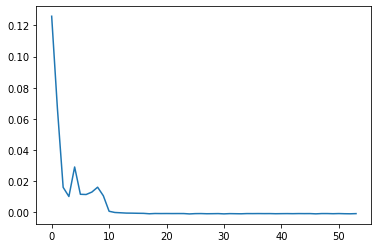

In [50]:
plt.plot(l)

Text(0.5, 1.0, 'LSTM, 20 Frames')

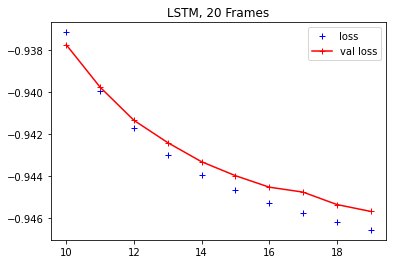

In [56]:
i =10
j=20
plt.plot(np.arange(i,j), lstm_20_history_1.history['loss'][i:j],'b+', label='loss')
plt.plot(np.arange(i,j), lstm_20_history_1.history['val_loss'][i:j],'r-+', label='val loss')

plt.legend()
plt.title('LSTM, 20 Frames')

In [60]:
lstm_20.evaluate(xx_test_abnorm,yy_test_abnorm)


11/11 [==============================] - 0s 10ms/step - loss: -0.8018 - mse: 0.0063


[-0.8018190264701843, 0.006331674288958311]

# Dense Network

In [ ]:
# Iou metric. Should probably scale back to normal. Might not matter if not scaled back to normal
class IouMetric(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.iou_avg = self.add_weight("iou_avg", initializer="zeros")
        self.bb_intersection_over_union = iou_function()
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true,y_pred):
        print('Here1')
        y_true = math_ops.cast(y_true, tf.float32)
        y_pred = math_ops.cast(y_pred, tf.float32)
        print('here')
        iou_calc =  self.bb_intersection_over_union(y_true,y_pred)
        self.iou_avg.assign_add(iou_calc)
        self.count.assign_add(1)
    def result(self):
        return self.iou_avg

In [ ]:
def custom_loss(y_actual,y_pred):
#     print(y_actual)
    kb.print_tensor(y_actual.shape)
    kb.print_tensor(y_pred)
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [ ]:
learning_rate = 0.0000005
dense_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=xx.shape[-2:]),
    keras.layers.Dense(4)
])
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dense_model.compile(loss="mse", optimizer=opt, metrics=bb_intersection_over_union)
# dense_model.compile(loss=custom_loss, optimizer=opt)
dense_model.compile(loss=bb_intersection_over_union, optimizer=opt, metrics = bb_intersection_over_union)

# history1 = dense_model.fit(xx, yy,validation_split=.1, 
#                     epochs=15)
# dense_history = dense_model.fit(train_univariate, epochs=5, validation_data =val_univariate  )
dense_history = dense_model.fit(xx,yy, epochs=6 )

            

In [ ]:
dense_model.summary()

In [ ]:
dense_history.history.keys()

In [ ]:
dense_model.evaluate(xx_test,yy_test)

In [ ]:
dense_model.evaluate(xx_test_abnorm,yy_test_abnorm)

In [ ]:
print(x_ppl_box.shape)
print(yy[:6])

In [ ]:
plt.plot(np.arange(1,51), dense_history.history['loss'],'b+', label='loss')
plt.plot(np.arange(1,51),dense_history.history['val_loss'], 'r+', label ='val loss')
plt.legend()
plt.title('Baseline Dense Network')

In [ ]:
plt.plot(np.arange(1,7), dense_history.history['loss'],'b+', label='loss')
plt.plot(np.arange(1,7), dense_history.history['val_loss'], 'r+', label ='val loss')
plt.legend()
plt.title('Baseline Dense Network Data Shuffled, lr = {}'.format(learning_rate))

In [ ]:
len(dense_history.history['loss'][30:51])

# Results creation

In [456]:
def videoPlot(y_ppl_box,y_pred, frame_ppl_id, video_file, vid_type ='test'):
    """
    Function is plotting the ground truth and predicted 
    
    y_ppl_box: Actual Label for bounding box locations
    y_ppl_box_pred: Prediction from Model of bounding box locations
    frame_person_id: Contains frame Number and person_Id of entire sequence, 
                     Last element is prediction frame. For visulization process
    video_file: Points to video file used. For visulization process
    """
    # Need a way to save images
    file = {}
    file['train'] = '/home/akanu/Dataset/Anomaly/Avenue_Dataset/training_videos/'
    file['test'] = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos/"
    loc_videos = file[vid_type] + video_file[:2] + '.avi'
    ###
    
    video_capture = cv2.VideoCapture(loc_videos)
    
#     for i in range(-1, frame_ppl_id[0,-1,0] + 1):
        #Assune sequences are connected and don't skip cuz of occlusions 
    for i in range(0,frame_ppl_id[0,-1,0]+1):
        print(i)
        ret, frame = video_capture.read()
        if i == frame_ppl_id[0,-1,0]:
            vid = int(video_file[:2])
            pred_frame = frame.copy()
            cv2.rectangle(frame, (int(y_ppl_box[0,0]), int(y_ppl_box[0,1])), (int(y_ppl_box[0,2]), int(y_ppl_box[0,3])),(255,255,255), 2)
            cv2.putText(frame, str(frame_ppl_id[0,-1,1]),(int(y_ppl_box[0,0]), int(y_ppl_box[0,1])),0, 5e-3 * 200, (0,255,0),2)

            cv2.rectangle(pred_frame, (int(y_pred[0,0]), int(y_pred[0,1])), (int(y_pred[0,2]), int(y_pred[0,3])),(255,255,0), 2)
            cv2.putText(pred_frame, str(frame_ppl_id[0,-1,1]),(int(y_pred[0,0]), int(y_pred[0,1])),0, 5e-3 * 200, (0,255,0),2)
            
            cv2.imwrite('/home/akanu/git/deep_sort_yolov3/Images_saved/{:02d}_{:02d}_pred.jpg'.format(vid,i), pred_frame)
            cv2.imwrite("/home/akanu/git/deep_sort_yolov3/Images_saved/{:02d}_{:02d}_gt.jpg".format(vid,i), frame)
            
            print('saved')


In [457]:
'/home/akanu/git/deep_sort_yolov3/Images_saved/{:02d}_{:02d}_{:02d}_pred.jpg'.format(1,20,900)

'/home/akanu/git/deep_sort_yolov3/Images_saved/01_20_900_pred.jpg'

In [464]:
def plot_single_videos(model,traindict,testdict):
    #Might need to go back and make normalize function more robust
    xx,yy, xx_test_abnorm, yy_test_abnorm, xx_test_norm, yy_test_norm = normalize_train_max_min(traindict=traindict, testdict=testdict)
    abnormal_dict, normal_dict = test_sepearate_norm_abnorm(testdict)

    
    vid_file,frame_ppl= abnorm_dict['video_file'], abnorm_dict['frame_ppl_id']
    y = abnorm_dict['y_ppl_box'] # not normailized
    
    for x,y_actual,frame_ppl_id, video_file,  in zip(xx_test_abnorm,y,frame_ppl,vid_file  ):  
        
        y_actual = np.expand_dims(y_actual,axis=0)
        frame_ppl_id =np.expand_dims(frame_ppl_id, axis=0)
        print(x)
        print(" {}  {} {}".format(y_actual, frame_ppl_id, frame_ppl_id[0,-1,0]))
        x = np.expand_dims(x,axis=0)
        y_pred = model.predict(x)
        y_pred = normalize_train_max_min(traindict=traindict, unnorm_data=y_pred, unorm=True)

        # if x,y,c,h change to right coordinates
        videoPlot(y_actual,y_pred, frame_ppl_id, video_file, vid_type ='test')
#         print(y_actual)
#         print(y_pred)
        
        

In [468]:
yy_test_abnorm[0:1].shape

(1, 4)

In [461]:
lstm_20.evaluate(testdict['x_ppl_box'],testdict['y_ppl_box'])

292/292 [==============================] - 3s 12ms/step - loss: 0.0000e+00 - mse: 104943.7656


[0.0, 104943.765625]